In [2]:
from tensorflow.keras.models import Sequential # НС прямого распространения
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization # Основные слои
from tensorflow.keras import utils # Утилиты для to_categorical
from tensorflow.keras.preprocessing import image # Для отрисовки изображения
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка изображений
from PIL import Image # Отрисовка изображений
import pandas as pd # Библиотека pandas
from sklearn.preprocessing import LabelEncoder, StandardScaler # Функции для нормализации данных
from sklearn import preprocessing # Пакет предварительной обработки данных
from sklearn.model_selection import train_test_split
from tensorflow.keras import metrics

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

In [3]:
cars = pd.read_csv('cars_new.csv', sep=',')
cars.head()

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [4]:
print(cars.values.shape)

(70119, 10)


In [5]:
# Создаём словарь поле - его индекс
def create_dict(s):
  ret = {}                          # Создаём пустой словарь
  for _id, name in enumerate(s):    # Проходим по всем парам - id и название
    ret.update({name: _id})         # Добавляем в словарь
  return ret

# Функция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [6]:
# Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

# Запоминаем цены
prices = np.array(cars['price'], dtype=float)

# Запоминаем числовые параметры
# и нормируем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

In [7]:
print(fuels_dict)

{'гибрид': 0, 'дизель': 1, 'газ': 2, 'бензин': 3, 'электро': 4}


In [8]:
volumes.mean()

1.2879530757014324e-16

In [9]:
volumes.std()

1.0

In [10]:
print(powers)

[ 0.22905575 -0.95630346 -0.87163494 ...  0.22905575 -0.75309902
  2.34576862]


In [11]:
# Создаём пустую обучающую выборку
x_train = []
y_train = []

# Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  # В y_train добавляем цену
  y_train.append(prices[_id])

  # В x_train объединяем все параметры
  # Категорийные параметры добавляем в виде ohe
  # Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]

  # Добавляем текущую строку в общий x_train
  x_train.append(x_tr)

# Превращаем лист в numpy.array
x_train = np.array(x_train, dtype=float)
y_train = np.array(y_train, dtype=float)

In [12]:
# Выводим размеры выборок
print(x_train.shape)
print(y_train.shape)

(70119, 3208)
(70119,)


In [13]:
# Выводим один x_train
print(x_train[0,:20])
print(x_train[0,-20:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[ 0.          0.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          1.5200145  -1.40018212
  0.12288486  0.22905575]


In [14]:
# Выводим y_train
print(y_train[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]


In [15]:
y_train.shape

(70119,)

In [16]:
y_train.reshape(-1,1).shape

(70119, 1)

In [17]:
# Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()

# y_train.reshape(-1,1) добавляет одну размерность
# Это нужно потому, что y_scaler.fit_transform
# Требует двумерны вектор, массив примеров, которые надо нормализовать
# Он не умеет работать с одним примеров
# Поэтому мы делаем массив из одного примера
# На выходе он так же выдаёт массив примеров
# Но нам нужен только первый пример
# Поэтому мы делаем flatten() - уменьшение размерности

In [18]:
y_train_scaled.shape

(70119,)

In [19]:
# Выводим базовый и нормированный y_train
print(y_train[:10])
print(y_train_scaled[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]
[ 0.75082432 -0.62135434  0.3563911   0.70913625 -0.51745486  0.73318706
  0.09824578 -0.04445567  1.27032173 -0.4132347 ]


In [20]:
X_train, x_test, Y_train, y_test = train_test_split(x_train, y_train_scaled, test_size=1/3, shuffle=True)

In [21]:
model_ula = Sequential([
  Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
  Dropout(0.3),
  Dense(64, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='linear')
])

model_ula.compile(
  optimizer='adam',
  loss='mae',
  metrics=[metrics.R2Score()]
)

history = model_ula.fit(
    X_train,
    Y_train,
    batch_size=8,
    epochs=100,
    validation_split=1/3,
    verbose=1
)

predict = model_ula.predict(x_test)


Epoch 1/100
3896/3896 [==============================] - 7s 2ms/step - loss: 0.1781 - r2_score: 0.7228 - val_loss: 0.1450 - val_r2_score: 0.8608
Epoch 2/100
3896/3896 [==============================] - 7s 2ms/step - loss: 0.1504 - r2_score: 0.7889 - val_loss: 0.1322 - val_r2_score: 0.8767
Epoch 3/100
3896/3896 [==============================] - 9s 2ms/step - loss: 0.1433 - r2_score: 0.8111 - val_loss: 0.1323 - val_r2_score: 0.8826
Epoch 4/100
3896/3896 [==============================] - 8s 2ms/step - loss: 0.1384 - r2_score: 0.8265 - val_loss: 0.1182 - val_r2_score: 0.8938
Epoch 5/100
3896/3896 [==============================] - 7s 2ms/step - loss: 0.1378 - r2_score: 0.8282 - val_loss: 0.1200 - val_r2_score: 0.9028
Epoch 6/100
3896/3896 [==============================] - 6s 2ms/step - loss: 0.1344 - r2_score: 0.8420 - val_loss: 0.1178 - val_r2_score: 0.9036
Epoch 7/100
3896/3896 [==============================] - 7s 2ms/step - loss: 0.1323 - r2_score: 0.8420 - val_loss: 0.1137 - val_r2

In [22]:
history.history.keys()

dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])

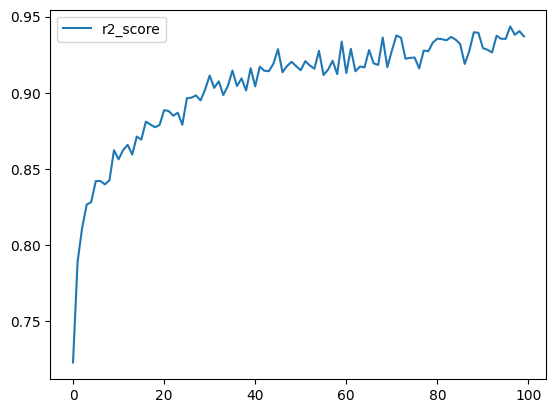

In [23]:
plt.plot(history.history['r2_score'], label='val_r2_score')
plt.legend(['r2_score'])
plt.show()

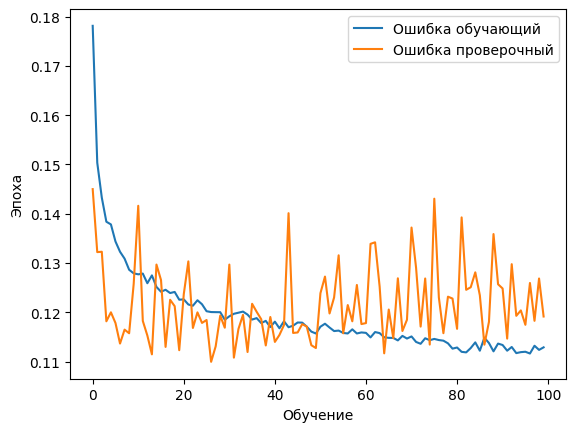

In [25]:
plt.plot(history.history['loss'], label='Ошибка обучающий')
plt.plot(history.history['val_loss'], label='Ошибка проверочный')
plt.xlabel('Обучение')
plt.ylabel('Эпоха')
plt.legend()
plt.show()